In [196]:
# setting environment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# supress warnings
import warnings
warnings.filterwarnings("ignore")

This is a Data Science practice problem I found on [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/all/practice?)

### Description
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

### Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

The data contains training set and testing set, training set has all the features and outcomes while testing set has only features, we will use the training set only to tune our model before submitting it online to run the real test data.

In [197]:
# reading csv file
data = pd.read_csv('data/Train.csv')

In [198]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [199]:
# randomize the order
data = data.sample(len(data))

In [200]:
# check the shape of data we have
data.shape

(614, 13)

In [201]:
# check the data type of each feature
data.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [202]:
# check the unique values of the categorical variables
cat = data.select_dtypes(include=['object'])
cat.nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

In [203]:
# Looks like Loan_ID is different for each example, this does not help much for our prediction, drop the column
data.drop(['Loan_ID'], axis=1, inplace=True)

In [204]:
# check the null value in each column
data.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Since we don't have many sample, it is best to deal with them first instead of dropping them directly

In [205]:
test.sum(1)

Gender
Female    112
Male      489
dtype: int64

In [206]:
# check Gender column
data['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [207]:
# since Male seems to dominate, will impute the null value with 'Male'
data['Gender'] = data['Gender'].fillna(value='Male')

In [208]:
# check Married column
data['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [209]:
# impute the null value with 'Yes' by the same logic
data['Married'] = data['Married'].fillna(value='Yes')

In [210]:
# check Dependents column
data['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [211]:
# impute null value with 0(mode)
data['Dependents'] = data['Dependents'].fillna(value='0')

In [212]:
# since dependent should be an ordered variable instead of simple nominal showing here, we will change them to 
# numeric value, with the case of 3+, we will simply replace them with 3
data['Dependents'] = data['Dependents'].str.replace('3+', '3', regex=False)
data['Dependents'] = pd.to_numeric(data['Dependents'])

In [213]:
# check Self_Employed column
data['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [214]:
# impute the null value with 'No'
data['Self_Employed'] = data['Self_Employed'].fillna(value='No')

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64


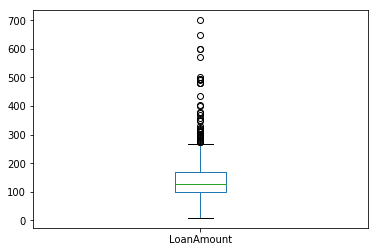

In [215]:
# check LoanAmount column
print(data['LoanAmount'].describe())
data['LoanAmount'].plot(kind='box')
plt.show()

In [216]:
# since there are some outliers in the column, we will use median instead of mean for imputing
data['LoanAmount'] = data['LoanAmount'].fillna(value=data['LoanAmount'].median())

In [217]:
# check Loan_Amount_Term column
data['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [218]:
# impute null value with the mode
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].fillna(value=data['Loan_Amount_Term'].mode()[0])

In [219]:
# check Credit_History column
data['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [220]:
# impute null value with the mode
data['Credit_History'] = data['Credit_History'].fillna(value=data['Credit_History'].mode()[0])

In [221]:
# check the Loan_Status outcome map the 'Y' to 1 and 'N' to 0
data['Loan_Status'] = data['Loan_Status'].map({'Y':1, 'N':0})

After finishing missing value imputing, we will explore some numeric feature distribution and see if there is any interesting phenomenon.

In [222]:
# we first plot the difference in each numeric column between group that get loan approval and group that did not
data.groupby(['Loan_Status']).mean()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,
0,0.729167,5446.078125,1877.807292,149.890625,344.56250,0.572917
1,0.751185,5384.068720,1504.516398,143.869668,341.43128,0.983412


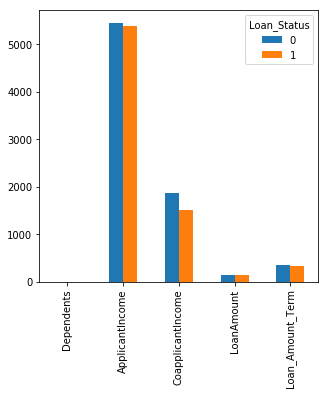

In [223]:
# we will deal with credit history column separately since its value is a lot lower than the others
data.groupby(['Loan_Status']).mean().drop(['Credit_History'], axis=1).transpose().plot(kind='bar', figsize=(5,5))
plt.show()

From the graph above, we can see that applicant income mean value is pretty much the same between group that got loan approval and group that did not, in contrast, coapplicant income result is a little bit counter ituitive, the group that got loan approval actually has lower coapplicant income value, there could be a chance that most applicant does not actually have co-applicants when applying loans and has a 0 value in that column, we can combine both to make a total income feature to and analyze together

In [224]:
# creating new feature total income
data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']

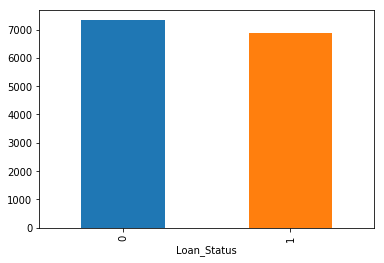

In [225]:
data.groupby(['Loan_Status']).mean()['Total_Income'].plot(kind='bar')
plt.show()

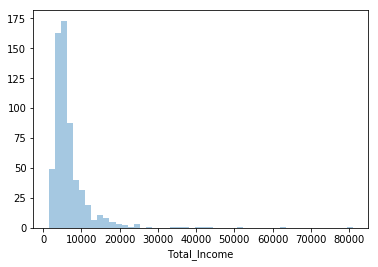

In [226]:
# plot the distribution of total income
sns.distplot(data['Total_Income'], kde=False)
plt.show()

We can see that the variable is right skewed, we will use the log transform to make it more normal distribution since this can make the cost fucntion minimize better the error of the predictions and to make the algorithm converge properly and faster

In [227]:
# tranform the data to normal distribution-like
data['Total_Income'] = np.log(data['Total_Income'])

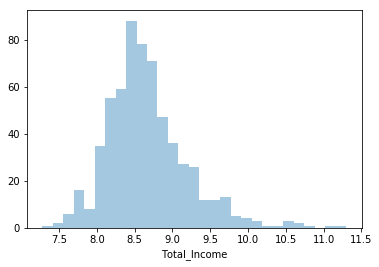

In [228]:
# replot to confirm
sns.distplot(data['Total_Income'], kde=False)
plt.show()

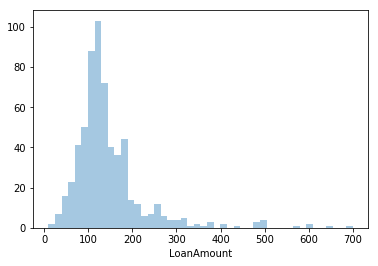

In [229]:
# check the LoanAmount column
sns.distplot(data['LoanAmount'], kde=False)
plt.show()

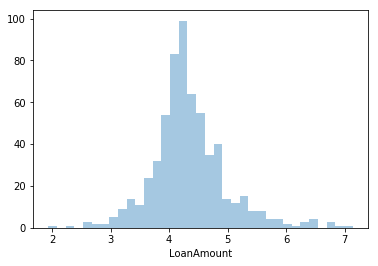

In [230]:
# we will try the power distribution for this column
data['LoanAmount'] = data['LoanAmount']**0.3
sns.distplot(data['LoanAmount'], kde=False)
plt.show()

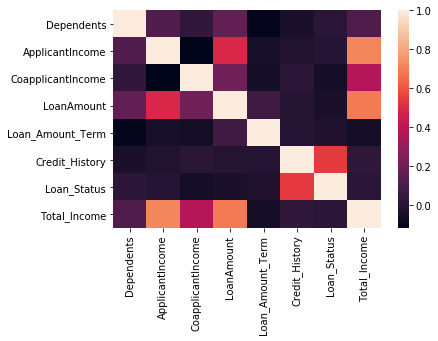

In [231]:
# plot seaborn heatmap to see if there is any high correlation data
sns.heatmap(data.corr())
plt.show()

In [232]:
# drop the old features that used to create the new feature to avoid multi-collinearity
data.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)

In [233]:
# before fitting our model, we need to get the dummy variables for our categorical features
data_clean = pd.concat([pd.get_dummies(data.drop('Loan_Status', axis=1)), data['Loan_Status']], axis=1)

In [234]:
data_clean.head()

,Dependents,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
334,1,4.764545,180.0,1.0,9.364434,0,1,0,1,1,0,0,1,0,0,1,1
146,2,3.577086,360.0,1.0,9.606832,1,0,0,1,1,0,1,0,0,0,1,1
172,3,3.737193,180.0,1.0,8.166784,0,1,0,1,0,1,1,0,1,0,0,0
568,0,1.933182,360.0,1.0,7.774015,1,0,1,0,1,0,1,0,0,0,1,0
583,1,3.432408,360.0,1.0,7.539027,0,1,0,1,1,0,1,0,1,0,0,0


We have done the cleaning process, before fitting the model, we need to split the training and testing set

In [235]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_clean.drop('Loan_Status', axis=1), data_clean['Loan_Status']
                                                    ,test_size=0.2, random_state=1009)

We will fit the vanilla logistic regression first

In [236]:
from sklearn.linear_model import LogisticRegression
# do not specify regularization parameter C, the default is 1(no regularization)
lg = LogisticRegression()
lg.fit(X_train, y_train)

print(lg.score(X_test, y_test))

0.7967479674796748


In [237]:
con_matrix = pd.crosstab(lg.predict(X_test), y_test)
con_matrix.index.rename('Predict', inplace=True)
con_matrix

Loan_Status,0,1
Predict,,
0,15,2
1,23,83


In [238]:
# cross validate to see whether the model has overfitting issue or not
from sklearn.model_selection import cross_val_score
cross_val_score(lg, data_clean.drop('Loan_Status', axis=1), data_clean['Loan_Status'], cv=10)

array([0.77777778, 0.84126984, 0.81967213, 0.75409836, 0.81967213,
       0.7704918 , 0.83606557, 0.80327869, 0.86885246, 0.80327869])

We can see that the score varies quite a bit, suggesting there might be some overfitting problem, we will start to fit our next model, ridge regression

In [239]:
# C is the inverse of regularization parameter
lg_ridge = LogisticRegression(penalty='l2', C=0.5)
lg_ridge.fit(X_train, y_train)

print(lg_ridge.score(X_test, y_test))

0.7967479674796748


In [240]:
cross_val_score(lg_ridge, data_clean.drop('Loan_Status', axis=1), data_clean['Loan_Status'], cv=10)

array([0.77777778, 0.84126984, 0.81967213, 0.75409836, 0.81967213,
       0.7704918 , 0.83606557, 0.80327869, 0.86885246, 0.80327869])

In [241]:
con_matrix = pd.crosstab(lg.predict(X_test), y_test)
con_matrix.index.rename('Predict', inplace=True)
con_matrix

Loan_Status,0,1
Predict,,
0,15,2
1,23,83


Looks like the ridge regression model performs the same as the vanilla linear regression, we will try the lasso regression to see how it performs

In [242]:
# C is the inverse of regularization parameter
lg_lasso = LogisticRegression(penalty='l1', C=100)
lg_lasso.fit(X_train, y_train)

print(lg_lasso.score(X_test, y_test))

0.7967479674796748


In [243]:
cross_val_score(lg_lasso, data_clean.drop('Loan_Status', axis=1), data_clean['Loan_Status'], cv=10)

array([0.77777778, 0.84126984, 0.81967213, 0.75409836, 0.81967213,
       0.7704918 , 0.83606557, 0.80327869, 0.86885246, 0.80327869])

In [244]:
con_matrix = pd.crosstab(lg.predict(X_test), y_test)
con_matrix.index.rename('Predict', inplace=True)
con_matrix

Loan_Status,0,1
Predict,,
0,15,2
1,23,83
